<a href="https://colab.research.google.com/github/WittmannF/LRFinder/blob/master/LRFinder_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Code

In [1]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr):
        self.min_lr = min_lr
        self.max_lr = max_lr
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        self.losses.append(loss)
        self.iteration += 1
        if loss > self.best_loss*10: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()
        

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step


W0712 18:44:40.864355 139692100679552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 18:44:40.899524 139692100679552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0712 18:44:40.923959 139692100679552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 18:44:40.952160 139692100679552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 18:44:40.987079 139692100679552 deprecation_wrappe

Epoch 1/1
35200/60000 [================>.............] - ETA: 3s - loss: 0.7632 - acc: 0.7718

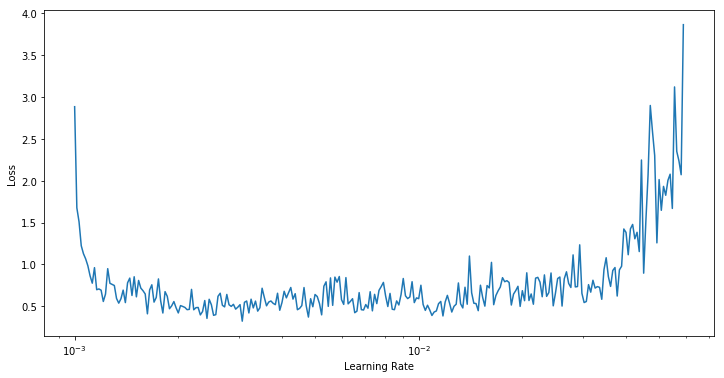

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

# Applying Moving Average

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*10: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Epoch 1/1
42752/60000 [====================>.........] - ETA: 1s - loss: 1.1501 - acc: 0.7437

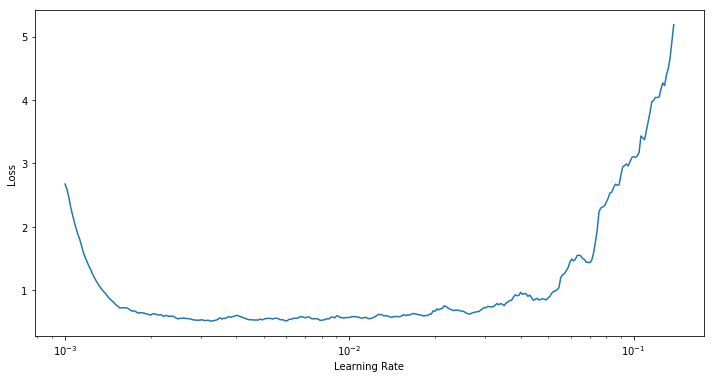

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0.9)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

# Automatic Stop Criteria

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9, 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Epoch 1/1
37376/60000 [=================>............] - ETA: 2s - loss: 0.7784 - acc: 0.7663

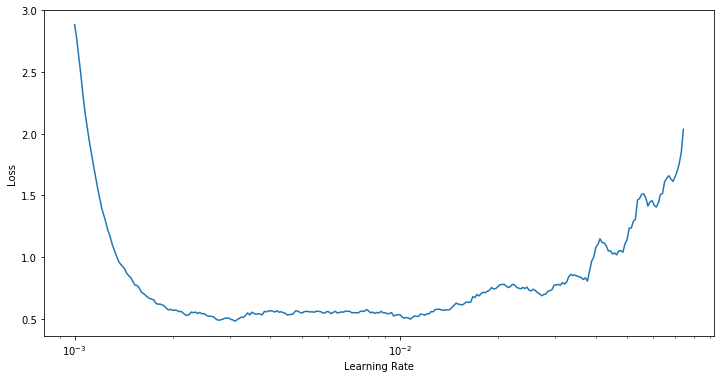

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0.9)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

# Handling Generators

In [1]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9, 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        try:
            n_iterations = self.params['samples']//self.params['batch_size']
        except:
            n_iterations = self.params['steps']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Using TensorFlow backend.


In [2]:
!git clone https://github.com/WittmannF/ImageDataGenerator-example.git

Cloning into 'ImageDataGenerator-example'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 341 (delta 4), reused 336 (delta 2), pack-reused 0
Receiving objects: 100% (341/341), 6.69 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# 1. Define Data Generators
DATA_PATH = 'ImageDataGenerator-example/flow_from_directory'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(DATA_PATH+'/train', target_size=(224, 224), class_mode="sparse")
valid_gen = datagen.flow_from_directory(DATA_PATH+'/valid', target_size=(224, 224), class_mode="sparse")

Found 256 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


W0712 18:51:06.552145 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 18:51:06.591642 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 18:51:06.598952 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 18:51:06.637737 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 6s 0us/step


W0712 18:51:13.793677 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 18:51:13.794985 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0712 18:51:17.210259 139702650046336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0712 18:51:17.307165 139702650046336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructi

Epoch 1/1
8/8 [==============================] - 9s 1s/step - loss: 4.4156 - acc: 0.6953 - val_loss: 8.0590 - val_acc: 0.5000


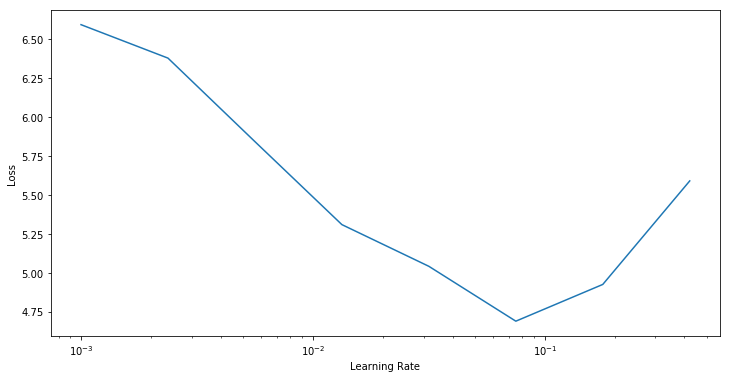

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# 2. Initialize base model
base_model = VGG16(include_top=False, input_shape=(224,224,3))

# 3. Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable=False

# 4. Add Fully connected layer
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer=Adam(lr=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0.9)

model.fit_generator(train_gen, 
                    train_gen.n//train_gen.batch_size, 
                    validation_data=valid_gen, 
                    validation_steps=valid_gen.n//valid_gen.batch_size,
                    callbacks=[lr_finder])

# Allowing Multiple Epochs

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9, 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        try:
            n_iterations = self.params['epochs']*self.params['samples']//self.params['batch_size']
        except:
            n_iterations = self.params['steps']*self.params['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [19]:
!git clone https://github.com/WittmannF/ImageDataGenerator-example.git

fatal: destination path 'ImageDataGenerator-example' already exists and is not an empty directory.


In [20]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# 1. Define Data Generators
DATA_PATH = 'ImageDataGenerator-example/flow_from_directory'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(DATA_PATH+'/train', target_size=(224, 224), class_mode="sparse")
valid_gen = datagen.flow_from_directory(DATA_PATH+'/valid', target_size=(224, 224), class_mode="sparse")

Found 256 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


Epoch 1/5
8/8 [==============================] - 4s 441ms/step - loss: 2.0934 - acc: 0.7930 - val_loss: 1.1925 - val_acc: 0.9062
Epoch 2/5
8/8 [==============================] - 2s 201ms/step - loss: 1.0090 - acc: 0.9102 - val_loss: 1.7652 - val_acc: 0.8906
Epoch 3/5
8/8 [==============================] - 2s 201ms/step - loss: 1.5111 - acc: 0.9062 - val_loss: 2.0148 - val_acc: 0.8750
Epoch 4/5
8/8 [==============================] - 2s 202ms/step - loss: 0.6932 - acc: 0.9570 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 5/5
8/8 [==============================] - 2s 202ms/step - loss: 6.6109 - acc: 0.5898 - val_loss: 8.0590 - val_acc: 0.5000


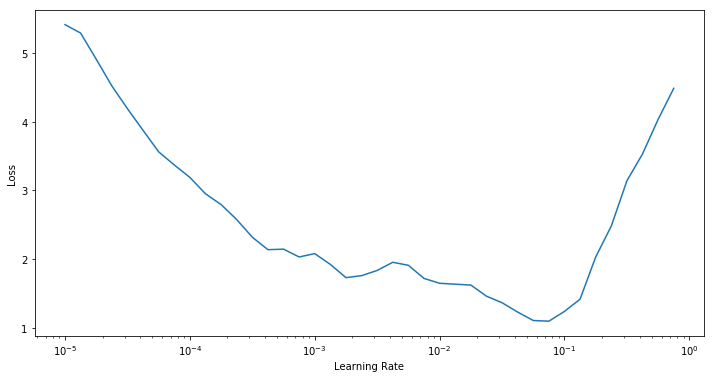

In [21]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# 2. Initialize base model
base_model = VGG16(include_top=False, input_shape=(224,224,3))

# 3. Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable=False

# 4. Add Fully connected layer
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer=Adam(lr=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

lr_finder = LRFinder(min_lr=1e-5, max_lr=1, mom=0.9)

model.fit_generator(train_gen, 
                    train_gen.n//train_gen.batch_size, 
                    validation_data=valid_gen, 
                    validation_steps=valid_gen.n//valid_gen.batch_size,
                    callbacks=[lr_finder],
                    epochs=5)

Epoch 1/2
60000/60000 [==============================] - 3s 45us/step - loss: 0.5719 - acc: 0.8029
Epoch 2/2
30848/60000 [==============>...............] - ETA: 0s - loss: 2.1066 - acc: 0.5474

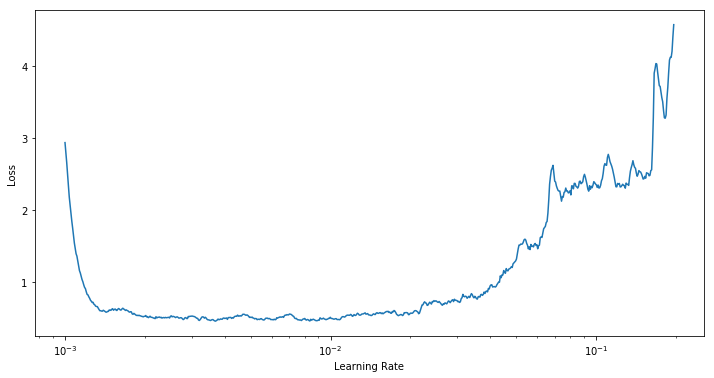

In [23]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0.9, stop_multiplier=10)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)

# Explonential Annealing
`start * (end/start) ** pct`

In [0]:
np.geomspace(0.001, 1, 20)

array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])

In [0]:
start = 0.001
end = 1
n_iterations = 20

lrs = []
for i in range(n_iterations):
    pct = i/(n_iterations-1)
    lrs.append(start * (end/start) ** pct)

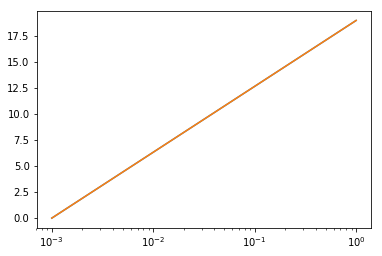

In [0]:
plt.plot(lrs, range(20))
plt.plot(np.geomspace(start, end, n_iterations), range(20))
plt.xscale('log')

In [0]:
lrs

[0.001,
 0.0014384498882876629,
 0.0020691380811147897,
 0.002976351441631318,
 0.004281332398719393,
 0.006158482110660264,
 0.008858667904100824,
 0.012742749857031336,
 0.018329807108324356,
 0.02636650898730358,
 0.03792690190732249,
 0.0545559478116852,
 0.07847599703514611,
 0.11288378916846893,
 0.16237767391887215,
 0.23357214690901226,
 0.3359818286283781,
 0.4832930238571754,
 0.6951927961775604,
 1.0]

In [0]:
np.geomspace(start, end, n_iterations)

array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9, 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        self.n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=self.n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        pct = self.iteration/self.n_iterations
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pct
        
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Epoch 1/1
 1664/60000 [..............................] - ETA: 1:29 - loss: 1.1096 - acc: 0.6136

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.311310). Check your callbacks.
  % delta_t_median)


32256/60000 [===============>..............] - ETA: 5s - loss: 0.6508 - acc: 0.7841

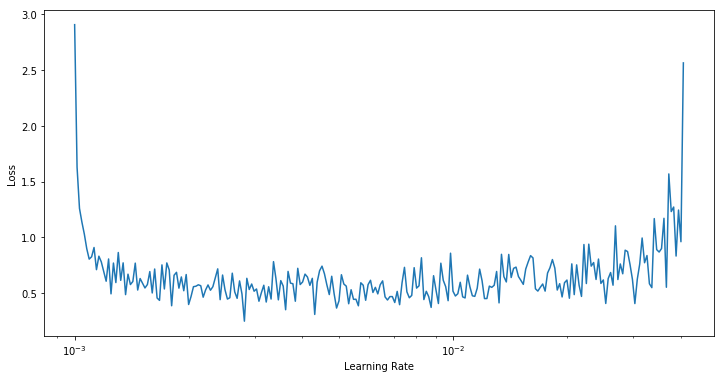

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

Loss function is not similar to the first one and it should be since mom = 0